# HW 2

Indywidualnie, zaimplementować model konwolucyjnej sieci neuronowej (CNN) do klasyfikacji w torch i przetestować go na wybranym zbiorze danych. Powstały raport w formatach .ipynb oraz .html powinien zawierać wnioski z przeprowadzonej analizy.

1 punkt uzyskuje się za pracę z zbiorem danych CIFAR10 (60k [take a subset: 1/3-1/2], 10 classes, 32x32 images)

2 punkty uzyskuje się za pracę z zbiorem danych OxfordIIITPet (7.4k, 37 classes, varied sizes of images)

3 punkty uzyskuje się za pracę z zbiorem danych StanfordCars (17k [if too large, take a subset], 196 classes, 360×240 images)


do 2 punktów uzyskuje się za wytrenowanie skutecznego modelu ResNet (porównać dwie wielkości, np. 18 i 34, na zbiorze treningowym i testowym)


1 punkt uzyskuje się za zaprezentowanie zwalczania zjawiska przeuczenia wykorzystując Dropout (lub inny sposób regularyzacji)


1 punkt uzyskuje się za zwizualizowanie macierzy konfuzji ORAZ pokazanie ozasadnionych/ciekawych przykłady obrazów, na których model się mylił


1 punkt uzyskuje się za zwizualizowanie wektora reprezentacji obrazów w podziale na klasy (kolor), wykorzystując PCA/TSNE (lub inny algorytm redukcji wymiaru)


do 2 punktów uzyskuje sie za jakość raportu (opisu, wizualizacji, kodu), a w szczególności agregację wyników w postaci tabel lub/i wykresów.


Uwaga! (1) Zabronione jest importowanie modeli z bibliotek; można korzystać z repozytoriów takich jak https://github.com/kuangliu/pytorch-cifar. (2) Warto zacząć od uczenia sieci na podzbiorze, np. 10%, danych treningowych (i ewaluowania na podzbiorze danych testowych) dla zaoszczędzenia czasu.

Praca domowa jest na 8 punktów (można uzyskać max 10 punktów).

## Wczytanie danych

In [4]:
pip install captum

In [5]:
# import standard PyTorch modules
import torch
import captum
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support


# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)  

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.device_count()

1

In [5]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [6]:
if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu"

In [7]:
torch.cuda.is_available()


True

In [6]:
cif = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
cif_t = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
test_cif, _ = torch.utils.data.random_split(cif_t, [2000, 8000])
train_cif, _ = torch.utils.data.random_split(cif, [10000, 40000])

Files already downloaded and verified
Files already downloaded and verified


## Resnet

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## RunBuilder

In [8]:
# import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.loader_test = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, loader_test):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.loader_test = loader_test
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images.to(DEVICE))

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images.to(DEVICE))

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

    self.epoch_loss_test = 0
    self.epoch_num_correct_test = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    self.tb.add_scalar('Accuracy_test', accuracy_test, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["accuracy_test"] = accuracy_test
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  def track_num_correct_test(self, preds, labels):
    self.epoch_num_correct_test += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

## Funkcja do modeli

In [9]:
def model_run(Network,params,epochs,train_set,test_set,name):
  m = RunManager()
  # get all runs from params using RunBuilder class
  for run in RunBuilder.get_runs(params):

      # if params changes, following line of code should reflect the changes too
      network = Network().to(DEVICE)
      loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
      loader_test = torch.utils.data.DataLoader(test_set, batch_size = run.batch_size)
      optimizer = optim.Adam(network.parameters(), lr=run.lr)

      m.begin_run(run, network, loader,loader_test)
      for epoch in range(epochs):
        
        m.begin_epoch()

        for batch in loader_test:
          images = batch[0].to(DEVICE)
          labels = batch[1].to(DEVICE)
          preds = network(images)
          m.track_num_correct_test(preds, labels)

        for batch in loader:
          
          images = batch[0].to(DEVICE)
          labels = batch[1].to(DEVICE)
          preds = network(images)
          loss = F.cross_entropy(preds, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          m.track_loss(loss)
          m.track_num_correct(preds, labels)

        m.end_epoch()
      m.end_run()

  # when all runs are done, save results to files
  m.save(name)
  return network

## Testowanie modeli ResNet

In [10]:
# put all hyper params into a OrderedDict, easily expandable
from collections  import OrderedDict
params = OrderedDict(
    lr = [.001],
    batch_size = [10,100],
    shuffle = [True]
)
params2 = OrderedDict(
    lr = [.001],
    batch_size = [300],
    shuffle = [True]
)
params3 = OrderedDict(
    lr = [.001],
    batch_size = [600],
    shuffle = [True]
)

In [14]:
_ = model_run(ResNet18,params,3,train_cif,test_cif,"cif_18")

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.891769,0.3093,0.0935,67.899154,68.413845,0.001,10,True
1,1,2,1.564757,0.4282,0.3540,67.866869,138.874779,0.001,10,True
2,1,3,1.356662,0.5098,0.4465,67.828714,209.303897,0.001,10,True
3,2,1,1.797040,0.3378,0.0995,32.088043,32.961219,0.001,100,True
4,2,2,1.419210,0.4715,0.4335,32.046418,67.594771,0.001,100,True
5,2,3,1.228005,0.5525,0.5055,32.207273,102.433621,0.001,100,True


Spróbujmy teraz wytrenować model dłużej ze zwiększonym batch_size = 300

In [15]:
cif_18 = model_run(ResNet18,params2,7,train_cif,test_cif,"cif_18v2")

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.936356,0.3083,0.1145,31.219902,33.156958,0.001,300,True
1,1,2,1.553219,0.4376,0.4065,31.302589,67.138322,0.001,300,True
2,1,3,1.379595,0.5002,0.4815,31.264740,101.066427,0.001,300,True
3,1,4,1.206437,0.5626,0.5245,31.243127,134.941804,0.001,300,True
4,1,5,1.059583,0.6256,0.5650,31.231437,168.878339,0.001,300,True
5,1,6,0.949994,0.6656,0.5865,31.231625,202.727604,0.001,300,True
6,1,7,0.825844,0.7087,0.6255,31.204703,236.606169,0.001,300,True


In [16]:
_ = model_run(ResNet34,params,3,train_cif,test_cif,"cif_34")

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.057984,0.2498,0.1000,126.173500,127.104669,0.001,10,True
1,1,2,1.777108,0.3391,0.3070,126.195642,258.231230,0.001,10,True
2,1,3,1.628654,0.4008,0.3700,126.347339,389.472546,0.001,10,True
3,2,1,1.913167,0.3050,0.0985,51.304415,52.707129,0.001,100,True
4,2,2,1.541066,0.4300,0.3865,51.395511,109.067161,0.001,100,True
5,2,3,1.348687,0.5032,0.4620,51.445273,165.618170,0.001,100,True


Teraz dłuższa wersja tak jak dla ResNet18 z batch_size = 600

In [18]:
cif_34 = model_run(ResNet34,params3,5,train_cif,test_cif,"cif_34v2")

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.237206,0.2264,0.1135,45.038049,50.222068,0.001,600,True
1,1,2,1.749369,0.3536,0.3305,43.846428,99.395875,0.001,600,True
2,1,3,1.564744,0.4256,0.3945,39.677707,144.363885,0.001,600,True
3,1,4,1.412216,0.4835,0.4700,37.522028,186.972602,0.001,600,True
4,1,5,1.289860,0.5262,0.5035,37.020497,229.087333,0.001,600,True


Przy aktualnym zbiorze danych 10k obserwacji w zbiorze treningowym, 2k w zbiorze walidującym, lepszym modelem jest ResNet18. Szybciej się uczy, przy mniejszym batchu daje lepsze wyniki. Z racji jego mniejszej złożoności przy większej ilości epok powinien być bardziej narażony na przetrenowania.

## Dropout

append_dropout: https://discuss.pytorch.org/t/where-and-how-to-add-dropout-in-resnet18/12869

In [1]:
def append_dropout(rate=0.2):
  model = ResNet18()
  for name, module in model.named_children():
      if len(list(module.children())) > 0:
        append_dropout(module)
      if isinstance(module, nn.ReLU):
        new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
        setattr(model, name, new)
  return model

In [1]:
_ = model_run(append_dropout(0.5),params2,6,train_cif,test_cif,"cif_18drop")

NameError: ignored

Problem z RAMem przy tym, ale i tak na małym zbiorze przy niewielkiej ilości epok nie zauważyliśmy zjawiska przeuczenia.

## Macierz konfuzji i błędnie zakwalifikowane obrazy

Zbudujmy jeszcze jeden model, tym razem na pełnym zbiorze danych.

In [36]:
cif_18v2 = model_run(ResNet18,params2,6,cif,cif_t,"cif_18v3")

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.404564,0.49246,0.1029,155.858205,157.831211,0.001,300,True
1,1,2,0.907491,0.67690,0.6202,156.741122,317.271280,0.001,300,True
2,1,3,0.684168,0.75950,0.7180,156.109163,476.087717,0.001,300,True
3,1,4,0.534095,0.81422,0.7527,156.156972,634.932984,0.001,300,True
4,1,5,0.423287,0.85348,0.7871,155.957046,793.540562,0.001,300,True
5,1,6,0.340869,0.88144,0.7938,156.067498,952.217862,0.001,300,True


macierz: https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html

In [46]:
from sklearn.metrics import confusion_matrix

@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([]).to(DEVICE)
  for batch in loader:
    images = batch[0].to(DEVICE)
    labels = batch[1].to(DEVICE)
    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0).to(DEVICE)

  return all_preds

test_loader = torch.utils.data.DataLoader(cif_t, batch_size = 300)
test_preds = get_all_preds(cif_18v2, test_loader)

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix
[[0.849 0.014 0.042 0.021 0.009 0.003 0.004 0.012 0.03  0.016]
 [0.003 0.921 0.002 0.004 0.002 0.001 0.007 0.001 0.009 0.05 ]
 [0.048 0.003 0.717 0.083 0.031 0.019 0.073 0.021 0.002 0.003]
 [0.019 0.006 0.045 0.73  0.026 0.062 0.057 0.033 0.014 0.008]
 [0.015 0.003 0.061 0.081 0.711 0.024 0.043 0.056 0.001 0.005]
 [0.007 0.002 0.032 0.235 0.021 0.636 0.022 0.041 0.001 0.003]
 [0.01  0.001 0.022 0.06  0.008 0.009 0.871 0.009 0.004 0.006]
 [0.01  0.003 0.021 0.042 0.022 0.025 0.004 0.863 0.001 0.009]
 [0.057 0.019 0.012 0.014 0.001 0.003 0.004 0.005 0.872 0.013]
 [0.027 0.055 0.003 0.005 0.001 0.002 0.002 0.008 0.023 0.874]]


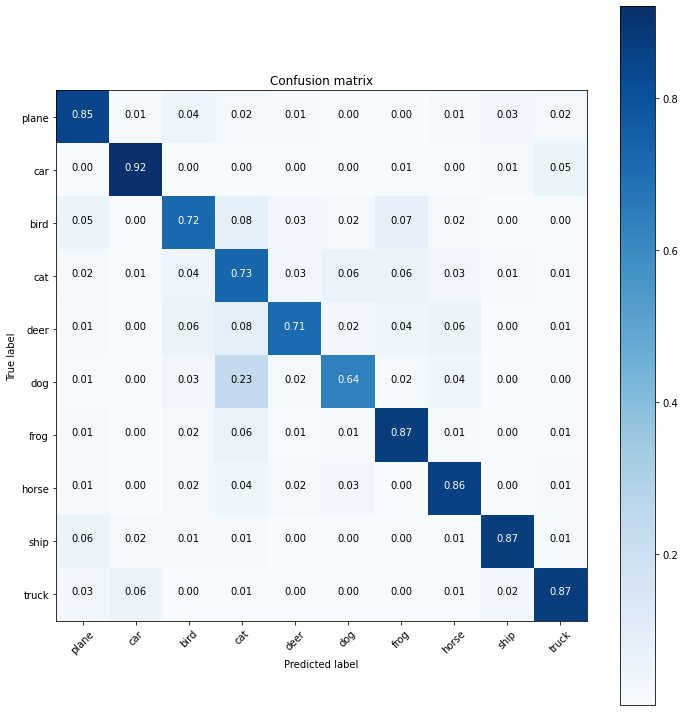

In [53]:
cm = confusion_matrix(cif_t.targets,test_preds.cpu().data.numpy().argmax(1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes,normalize=True)

Sprawdźmy ciekawe, błędnie zakwalifikowane obrazy

In [64]:
def error_pictures(k,m,title):
  mistakes = []
  p = test_preds.argmax(dim=1)

  for i in range(len(cif_t.targets)):
    if cif_t.targets[i] == k:
      if p[i] == m:
        mistakes += [i]

  for i in range(len(mistakes)):
    images, labels = cif_t[mistakes[i]]
    plt.title(title)
    plt.imshow(images.cpu().permute(1, 2, 0))
    plt.axis("off")
    print(labels)
    plt.show()

0


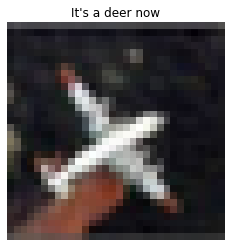

0


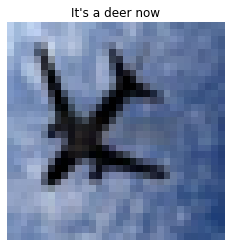

0


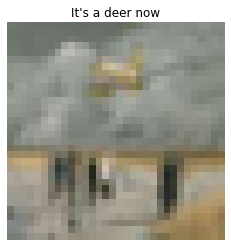

0


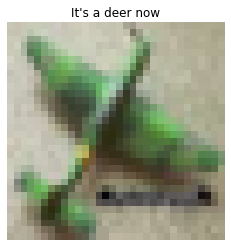

0


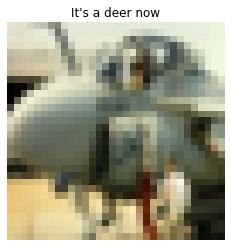

0


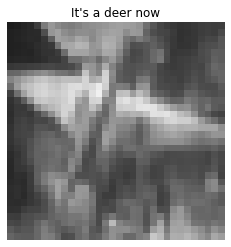

0


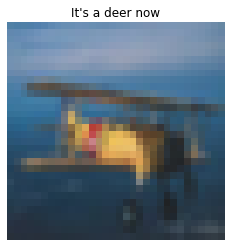

0


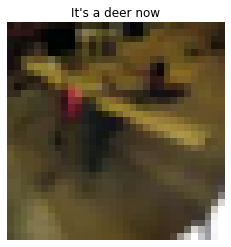

0


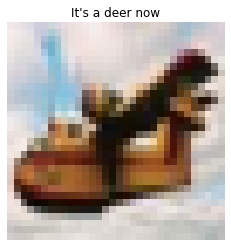

In [65]:
error_pictures(0,4,"It's a deer now")

9


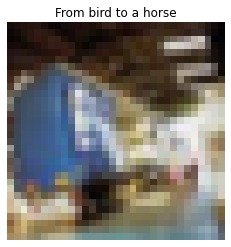

9


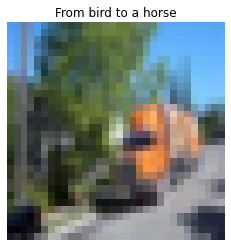

In [67]:
error_pictures(9,6,"From a truck to a frog")

## Zapis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp -av './runs/' '/content/gdrive/My Drive/temp-runs'
